<h1> <b>Raw data를 활용한 이상감지 및 잔여수명 예측 가능 여부 판단</b></h1>
&nbsp;

- <h3> <b>데이터 : <a href="https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/">[Turbofan Engine Degradation Simulation Data Set]</a></b></h3>

     - <h4> <b>train data : Run-to-Failure data</b> </h4>
     - <h4> <b>test data : Censored data</b> </h4>

- <h3> <b>이상감지 : MSET (Multivariate State Estimation Technique) 기법을 활용하여 이상감지 수행</b> </h3>
- <h3> <b>잔여수명 예측 : PoF (Physics of Failure) 기반 잔여수명 예측을 목표로 함</b> </h3>

In [1]:
# 개인 함수 불러오기
src_dir = 'E:\\R\\prototype5\\function\\'
src_file = list.files(src_dir)
for(i in 1:length(src_file)) source(paste(src_dir, src_file[i], sep=''), encoding='utf-8')

In [2]:
# data import
# Train Dataset 
trainData = read.table('E:\\데이터\\예지보전\\CMAPSSData\\train_FD001.txt')
# testDataset 
testData = read.table('E:\\데이터\\예지보전\\CMAPSSData\\test_FD001.txt')

# column name 정의
colname = c()
for(i in 0:25){
  colname = append(colname, paste0('Section-',i))
}
colnames(trainData) = colname
colnames(testData) = colname

In [3]:
# 데이터 요약
summary(trainData)

   Section-0        Section-1       Section-2           Section-3         
 Min.   :  1.00   Min.   :  1.0   Min.   :-8.70e-03   Min.   :-6.000e-04  
 1st Qu.: 26.00   1st Qu.: 52.0   1st Qu.:-1.50e-03   1st Qu.:-2.000e-04  
 Median : 52.00   Median :104.0   Median : 0.00e+00   Median : 0.000e+00  
 Mean   : 51.51   Mean   :108.8   Mean   :-8.87e-06   Mean   : 2.351e-06  
 3rd Qu.: 77.00   3rd Qu.:156.0   3rd Qu.: 1.50e-03   3rd Qu.: 3.000e-04  
 Max.   :100.00   Max.   :362.0   Max.   : 8.70e-03   Max.   : 6.000e-04  
   Section-4     Section-5       Section-6       Section-7      Section-8   
 Min.   :100   Min.   :518.7   Min.   :641.2   Min.   :1571   Min.   :1382  
 1st Qu.:100   1st Qu.:518.7   1st Qu.:642.3   1st Qu.:1586   1st Qu.:1402  
 Median :100   Median :518.7   Median :642.6   Median :1590   Median :1408  
 Mean   :100   Mean   :518.7   Mean   :642.7   Mean   :1591   Mean   :1409  
 3rd Qu.:100   3rd Qu.:518.7   3rd Qu.:643.0   3rd Qu.:1594   3rd Qu.:1415  
 Max.   :100 

In [4]:
# 변수 별 분산
apply(trainData, 2, var)

Section-0    Section-1    Section-2    Section-3    Section-4    Section-5 
8.542545e+02 4.744591e+03 4.784340e-06 8.588541e-08 0.000000e+00 0.000000e+00 
   Section-6    Section-7    Section-8    Section-9   Section-10   Section-11 
2.500533e-01 3.759099e+01 8.101089e+01 0.000000e+00 1.929279e-06 7.833883e-01 
  Section-12   Section-13   Section-14   Section-15   Section-16   Section-17 
5.038938e-03 4.876536e+02 0.000000e+00 7.133568e-02 5.439850e-01 5.172330e-03 
  Section-18   Section-19   Section-20   Section-21   Section-22   Section-23 
3.639005e+02 1.406628e-03 0.000000e+00 2.398667e+00 0.000000e+00 0.000000e+00 
  Section-24   Section-25 
3.266927e-02 1.171825e-02

In [5]:
# 분산이 0인 변수 및 불필요 변수 제거
train = trainData[,-c(which(apply(trainData, 2, var) == 0), 2,11)] 
test = testData[,-c(which(apply(trainData, 2, var) == 0), 2, 11)] 

In [6]:
head(train)

Section-0,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
1,-0.0007,-4e-04,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,0.0019,-3e-04,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
1,-0.0043,3e-04,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
1,0.0007,0e+00,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
1,-0.0019,-2e-04,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
1,-0.0043,-1e-04,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669


In [7]:
head(test)

Section-0,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
1,0.0023,3e-04,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,-0.0027,-3e-04,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
1,0.0003,1e-04,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
1,0.0042,0e+00,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
1,0.0014,0e+00,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130
1,0.0012,3e-04,642.11,1579.12,1395.13,554.22,2388.00,9050.96,47.26,521.92,2388.08,8127.46,8.4238,392,38.91,23.3467


  [1] 192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 [19] 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 [37] 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 [55] 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 [73] 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 [91] 135 341 155 258 283 336 202 156 185 200


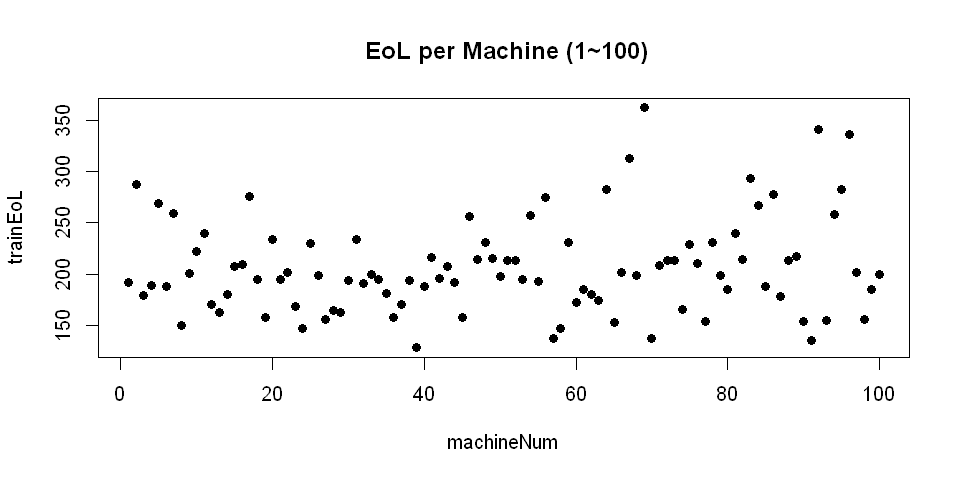

In [8]:
# Machine Number
machineNum = as.numeric(names(table(train$'Section-0')))
# EoL (End of Life)
trainEoL = as.numeric(table(train$'Section-0'))
testEoL = read.table('E:\\데이터\\예지보전\\CMAPSSData\\EoL_FD001.txt')
testEoL = testEoL$V1

# library(repr)
options(repr.plot.width = 8, repr.plot.height = 4)
plot(machineNum, trainEoL, pch=16, main = ' EoL per Machine (1~100)')
print(trainEoL)

In [9]:
# Machine 별로 데이터 보기 & 모델링을 위해 머신 정보 제거
machineNum = 1
trainM =train[train$`Section-0`== machineNum, -1]
testM =test[test$`Section-0`== machineNum, -1] 

In [10]:
head(trainM)

Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
-0.0007,-4e-04,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
0.0019,-3e-04,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
-0.0043,3e-04,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
0.0007,0e+00,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
-0.0019,-2e-04,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
-0.0043,-1e-04,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669


In [11]:
head(testM )

Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0.0023,3e-04,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
-0.0027,-3e-04,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
0.0003,1e-04,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
0.0042,0e+00,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
0.0014,0e+00,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130
0.0012,3e-04,642.11,1579.12,1395.13,554.22,2388.00,9050.96,47.26,521.92,2388.08,8127.46,8.4238,392,38.91,23.3467


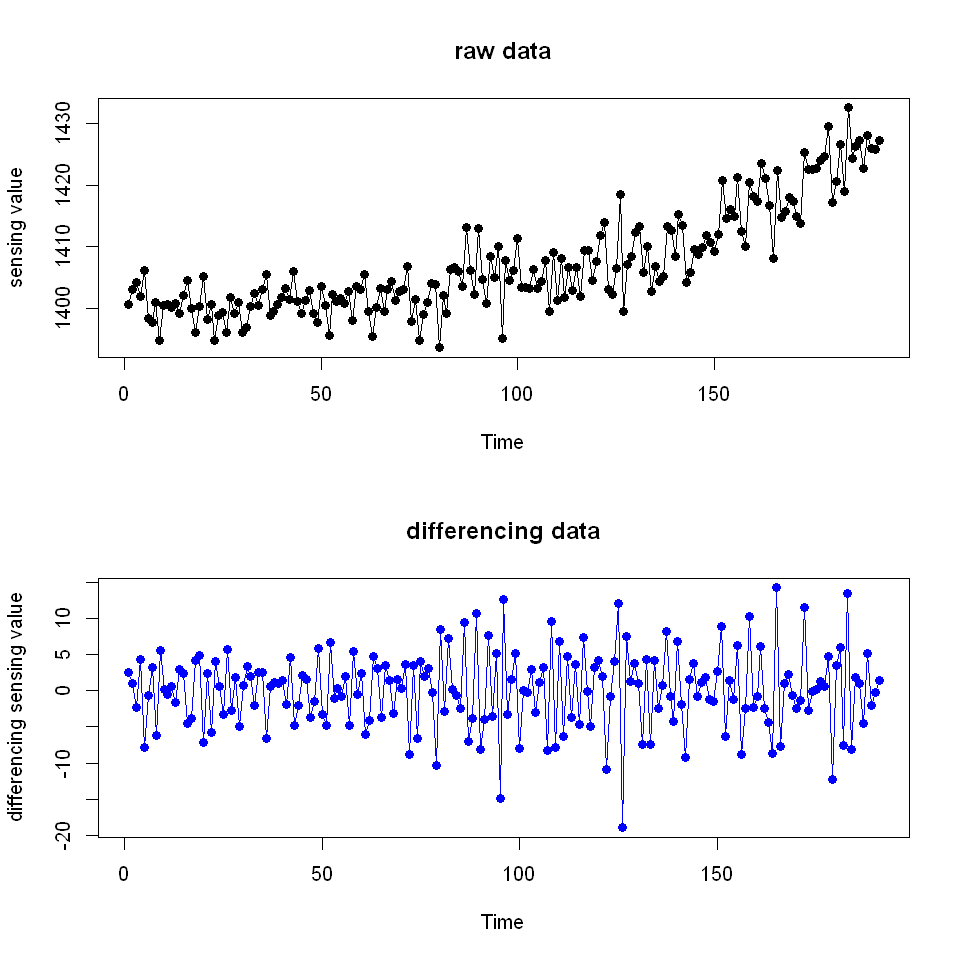

In [12]:
# raw 데이터 & differencing data 시각화
colNum = 5

par(mfrow=c(2,1))
options(repr.plot.width = 8, repr.plot.height = 8)

plot(trainM[,colNum], pch=16, type='o', main='raw data', xlab='Time', ylab='sensing value')
plot(diff(trainM[,colNum]), pch=16, type='o', main='differencing data', xlab='Time', ylab='differencing sensing value', col='blue')

- <h4> 위 그래프는 Raw 데이터와 차분한 데이터를 나타냄 </h4>
- <h4> 위 그래프를 봤을때, 해당 항공기 터빈엔진 데이터는 변동성이 굉장히 큰 데이터임 (노이즈가 많음) </h4>
- <h4> 추후에 Smoothing 작업을 통해 노이즈를 줄일 필요가 있음 </h4>

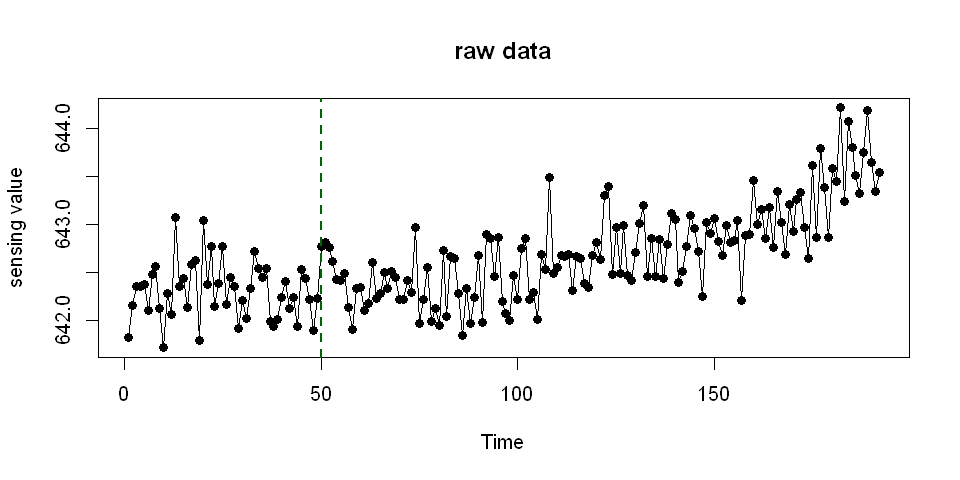

In [13]:
# 이상감지를 위한 정상 분포 설정 (임의로 1~50까지의 Raw를 healthy state로 설정)
par(mfrow=c(1,1))
options(repr.plot.width = 8, repr.plot.height = 4)
colNum = 3
plot(trainM[,colNum], pch=16, type='o', main='raw data', xlab='Time', ylab='sensing value')
abline(v=50, lty=2, lwd=2, col='darkgreen')

## Anomaly Detection : MSET Regression

In [14]:
# MSET Regression 수행 (사용모델 : Linear Regression)
mrtr = mset_regress(trainM[1:50,], trainM)
mrts = mset_regress(trainM[1:50,], testM)

In [15]:
head(mrts$residual_ts)

Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0.0025617170,2.499470e-04,1.04310631,-0.9134757,-1.7608077,0.02717737,1.0522935,-1.8223039,-0.079148116,-0.09288465,1.0526266,-5.78946932,-0.0006584701,0.08250423,-0.055933834,0.003593525
-0.0031402950,-2.972004e-04,-0.82141986,-2.0424597,-6.0724874,0.22689053,-1.5659683,5.5198536,0.193713508,0.04883081,-1.4746896,8.52167303,-0.0345597091,0.85799152,0.003172934,-0.020164023
0.0008642121,4.522589e-05,0.02854664,0.7392545,0.7144962,-0.01362643,-0.4383615,5.3257702,0.179162919,-0.26767583,-0.4607574,-1.19910230,0.0328741671,0.79160553,0.146178231,0.032490165
0.0057604074,-1.228628e-05,0.05364380,-0.8950093,5.5479790,-0.07757756,0.3090751,-4.3305639,0.006119215,-0.75330142,0.3283273,0.05285215,-0.0270501182,-0.76199665,0.048869010,-0.022990102
0.0021907685,-3.167572e-06,0.41779692,1.3909621,2.0187568,0.25719815,0.9941945,-5.5603868,0.031617775,0.25994166,1.0187186,-3.56464664,-0.0077139381,-1.77412181,0.028543142,0.021516321
0.0012060015,2.229161e-04,0.12941528,-8.6174415,-6.1367563,-0.01053342,0.6202058,0.1651976,0.021573614,0.23226282,0.7431170,-1.50302113,0.0146472221,0.18078106,0.024087859,-0.012177269


- <h4> 위 결과는 Raw 데이터에 MSET Regression 적용 결과로 잔차를 나타냄 </h4>
- <h4> Scaling을 하지 않았기 때문에 Scalar 값이 큰 변수의 영향력이 커지는 현상 발생 </h4>
- <h4> 추후에 Scaling 작업 필요 </h4>

In [16]:
# MSET Modeling -> Visualization
autoMSET <- function(train, test, healthystate, machineNum){
    # MSET Regression 수행 (사용모델 : Linear Regression)
    mrtr = mset_regress(train[healthystate,], train)
    mrts = mset_regress(train[healthystate,], test)
    
    
    # control limit
    cl = bootlimit(rowSums(mrtr$residual_tr), alpha=0.05)
    
    # ploting
    options(repr.plot.width = 8, repr.plot.height = 8)
    par(mfrow=c(2,1))
    plot(rowSums(mrtr$residual_ts), pch=16, type='o', main=paste0(" Train MSET Statistics (Machine ",machineNum,')'), xlab='Time', ylab='Residual', col='blue')
    abline(h=cl, col='red')
    abline(v=50, lty=2, lwd=1, col='darkgreen')
    abline(v=which(rowSums(mrtr$residual_ts)>cl), col=adjustcolor('red', alpha=0.2))
    
    plot(rowSums(mrts$residual_ts), pch=16, type='o', main=paste0(" Test MSET Statistics (Machine ",machineNum,')'), xlab='Time', ylab='Residual',col='blue')
    abline(v=which(rowSums(mrts$residual_ts)>cl), col=adjustcolor('red', alpha=0.2))
    abline(h=cl, col='red')
    
    # EoL information
    cat('\n')
    cat(sprintf('Machine %d', machineNum))
    cat(sprintf('\nTrain EoL : %d',trainEoL[machineNum]))
    cat(sprintf('\nTest EoL : %d',testEoL[machineNum]))
}


Machine 23
Train EoL : 168
Test EoL : 243

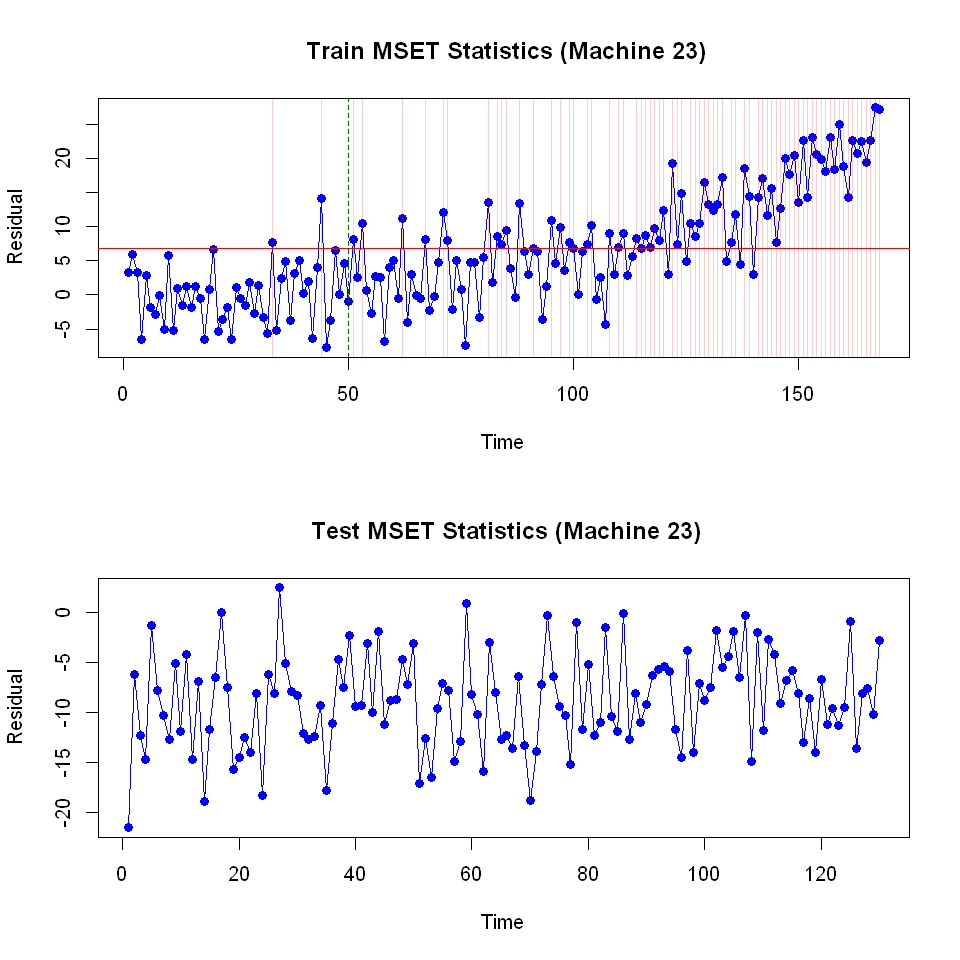

In [17]:
machineNum = 23
trainM =train[train$`Section-0`== machineNum, -1]
testM =test[test$`Section-0`== machineNum, -1] 
autoMSET(trainM, testM, healthystate=1:50, machineNum=machineNum)

- <h4> 위 그래프는 Train 데이터의  MSET 통계량과 Test 데이터의 MSET 통계량을 나타냄 (정상분포 : Train 데이터  1~50까지의 값) </h4>
- <h4> CL (Control Limit) 은 정상분포에서 유의수준 0.05 수준에서 bootstrap sampling을 통해 추출하였음 </h4>
- <h4> Train 데이터의 경우 대부분 고장시점과 가까워질수록 전조증상이 존재 </h4>
- <h4> Test 데이터의 경우 이상감지 통계량이 명확한 패턴 (Machine : 20, 21, 32, 90 등) 일부 있음 </h4>
- <h4> Test 데이터의 경우 이상감지 통계량으로 전조증상을 확인하기엔  대부분 명확하게 판단하기엔 어려움 (Machine : 45, 47, 50 등) </h4>
- <h4> 또한 Test 데이터의 경우  정상분포를 기준으로 설정된 Control limit 값에 크게 벗어나는 패턴도 존재 (Machine : 23, 41 등) </h4>

## Degradation Model

In [18]:
# Degradation Model 
machineNum = 1
trdeg = degradation_model(residual = mrtr$'residual_ts')
tsdeg = degradation_model(residual = mrts$'residual_ts')
head(tsdeg$degradation)

0.002561717,0.0002499470,1.0431063,0.9134757,1.760808,0.02717737,1.0522935,1.822304,0.07914812,0.09288465,1.0526266,5.789469,0.0006584701,0.08250423,0.05593383,0.003593525
0.002851006,0.0002735737,0.9322631,1.4779677,3.916648,0.12703395,1.3091309,3.671079,0.13643081,0.07085773,1.2636581,7.155571,0.0176090896,0.47024787,0.02955338,0.011878774
0.002188741,0.0001974578,0.6310243,1.2317299,2.849264,0.08923144,1.0188744,4.222643,0.15067485,0.13646376,0.9960246,5.170082,0.0226974488,0.57736709,0.06842833,0.018749238
0.003081658,0.0001511649,0.4866791,1.1475498,3.523943,0.08631797,0.8414246,4.249623,0.11453594,0.29067318,0.8291003,3.890774,0.0237856161,0.62352448,0.06353850,0.019809454
0.002903480,0.0001215654,0.4729027,1.1962322,3.222905,0.12049401,0.8719786,4.511776,0.09795231,0.28452687,0.8670239,3.825549,0.0205712805,0.85364395,0.05653943,0.020150827
0.002620567,0.0001384572,0.4156548,2.4331005,3.708547,0.10216724,0.8300165,3.787346,0.08522252,0.27581620,0.8463728,3.438461,0.0195839375,0.74150013,0.05113083,0.018821901


- <h4> 위 결과는 Raw 데이터에 MSET Regression 적용 후, MSET Regression의 잔차값을 Degradation Model에 적용한 결과임 </h4>
- <h4> Degradation Model은 Stress-Damage approach로 잔차를 스트레스 지표로 사용하며, 누적된 잔차값을 이용하여 설비 진단 </h4>
- <h4> 마찬가지로 Scaling을 하지 않았기 때문에 Scalar 값이 큰 변수의 영향력이 커지는 현상 발생 </h4>
- <h4> 추후에 Scaling 작업 필요 </h4>

In [19]:
# MSET Modeling -> Degradation Modeling -> Visualization
autoDegradation <- function(train, test, healthystate, PoF, machineNum){
    
    # MSET Regression 수행 (사용모델 : Linear Regression)
    mrtr = mset_regress(train[healthystate,], train)
    mrts = mset_regress(train[healthystate,], test)
      
    trdeg = degradation_model(residual = mrtr$'residual_ts')
    tsdeg = degradation_model(residual = mrts$'residual_ts')
    
    # ploting
    options(repr.plot.width = 8, repr.plot.height = 8)
    par(mfrow=c(2,1))
    range = c(rowSums(trdeg$degradation), PoF)
    plot(rowSums(trdeg$degradation), pch=16, type='o', main=paste0(" Train Degradation Statstics (Machine ",machineNum,')'), xlab='Time', ylab='Residual', col='blue', ylim=c(min(range),max(range)))
    abline(v=50, lty=2, lwd=1, col='darkgreen')
    abline(h=PoF, col='red')
    
    range = c(rowSums(tsdeg$degradation), PoF)
    plot(rowSums(tsdeg$degradation), pch=16, type='o', main=paste0(" Test Degradation Statstics (Machine ",machineNum,')'), xlab='Time', ylab='Residual',col='blue', ylim=c(min(range),max(range)))
    abline(h=PoF, col='red')
    
    # EoL information
    cat('\n')
    cat(sprintf('Machine %d', machineNum))
    cat(sprintf('\nTrain EoL : %d',trainEoL[machineNum]))
    cat(sprintf('\nTest EoL : %d',testEoL[machineNum]))
    
    return(
        list(
            trdeg = rowSums(trdeg$degradation),
            tsdeg = rowSums(tsdeg$degradation)
        )
    )
}

# PoF extraction of 100 machines
PoFextraction <- function(train, healthystate){
    PoFList = c()
    for(i in as.numeric(names(table(train$'Section-0')))){
        trainM =train[train$`Section-0`== i,-1]
        mrtr = mset_regress(trainM[healthystate,], trainM)
        trdeg = degradation_model(residual = mrtr$'residual_ts')
        degsum = rowSums(trdeg$'degradation')
        PoF = degsum[length(degsum)]
        PoFList = append(PoFList, PoF)
    }
    return(PoFList)
}

In [20]:
PoFList = PoFextraction(train, 1:50)
PoF = mean(PoFList)
uPoF = mean(PoFList) + 3*sd(PoFList)
lPoF = mean(PoFList) - 3*sd(PoFList)

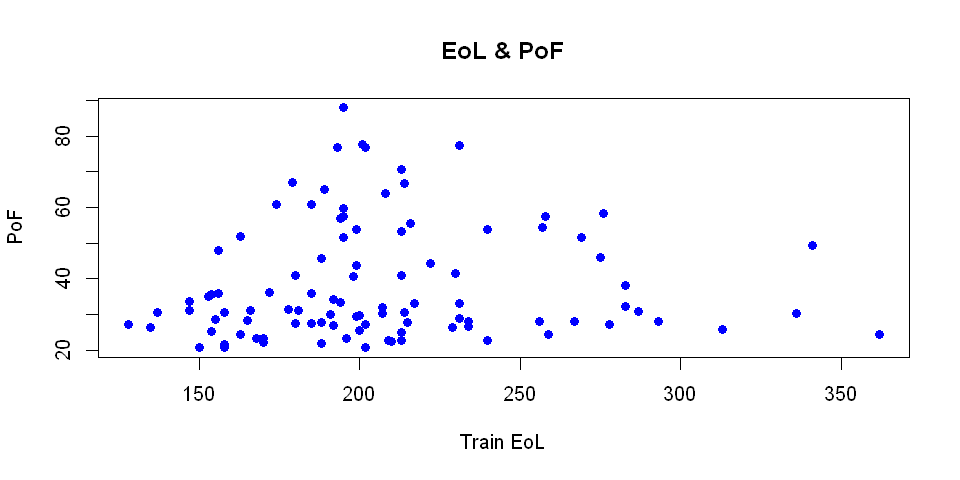

In [21]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,1))  
plot(as.numeric(table(train$'Section-0')), PoFList, xlab='Train EoL', ylab='PoF', pch=16, main = "EoL & PoF", col='blue')

##### - 위 그래프는 Train데이터 -> MSET Regression -> Degradation Model에서 추출한 PoF값과 실제 Train 데이터의 EoL 간의 관계를 표현한 그래프임  



Machine 90
Train EoL : 154
Test EoL : 174

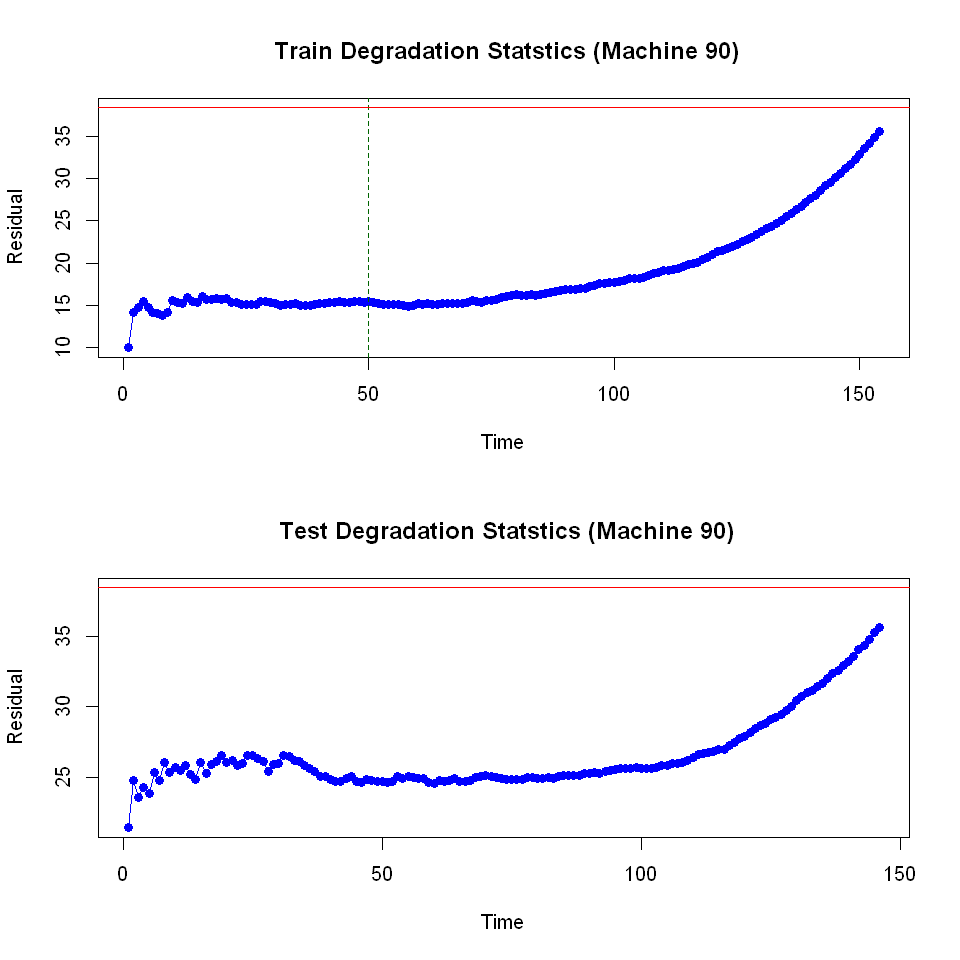

In [22]:
machineNum = 90
trainM =train[train$`Section-0`== machineNum, -1]
testM =test[test$`Section-0`== machineNum, -1] 
deg = autoDegradation(trainM, testM, healthystate=1:50, PoF=mean(PoF), machineNum=machineNum)

- <h4> 위 그래프는 Degradation Model과 PoF 시각화를 나타냄 </h4>
- <h4> 대부분의 데이터의 경우 전조증상이 나타나지 않거나, PoF값을 조기에 통과했음 </h4>
- <h4> 이는 Raw 데이터를 이용해서 잔여수명 예측이 어려움을 나타남 </h4>
- <h4> 또한 현재 PoF값을 100대 설비에 대한 평균을 이용하였으나, PoF값을 고도화해서 설정할 필요가 있음 </h4>
- <h4> 잔여수명 예측은 Machine 17, 82, 90의 경우 잔여수명 예측이 가능할 것으로 사료됨 </h4>

In [23]:
traindeg = c()
testdeg = c()
# Machine 별로 데이터 보기 & 모델링을 위해 머신 정보 제거
for(machineNum in 1:100){
    trainM =train[train$`Section-0`== machineNum, -1]
    testM =test[test$`Section-0`== machineNum, -1] 
    
    # MSET Regression 수행 (사용모델 : Linear Regression)
    mrtr = mset_regress(trainM[1:50,], trainM)
    mrts = mset_regress(trainM[1:50,], testM)
    
     # Degradation Model 
    trdeg = degradation_model(residual = mrtr$'residual_ts')
    tsdeg = degradation_model(residual = mrts$'residual_ts')
    
    traindeg = append(traindeg, rowSums(trdeg$degradation))
    testdeg = append(testdeg, rowSums(tsdeg$degradation))
}

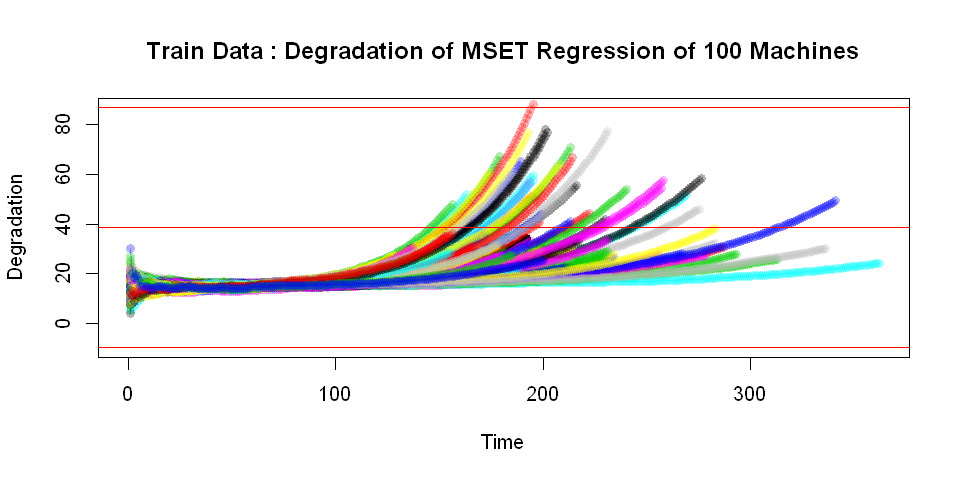

In [24]:
options(repr.plot.width = 8, repr.plot.height = 4)
plot(traindeg[train['Section-0']==1], pch=16, xlab='Time', ylab='Degradation', type='o', xlim = c(0,max(trainEoL)), ylim=c(lPoF, uPoF))
for(machineNum in 2:100){
    points(traindeg[train['Section-0']==machineNum], pch=16, col=adjustcolor(machineNum, alpha=0.3), type='o')
 }
title("Train Data : Degradation of MSET Regression of 100 Machines")
abline(h=mean(PoFList), col='red')
abline(h=uPoF, col='red')
abline(h=lPoF, col='red')

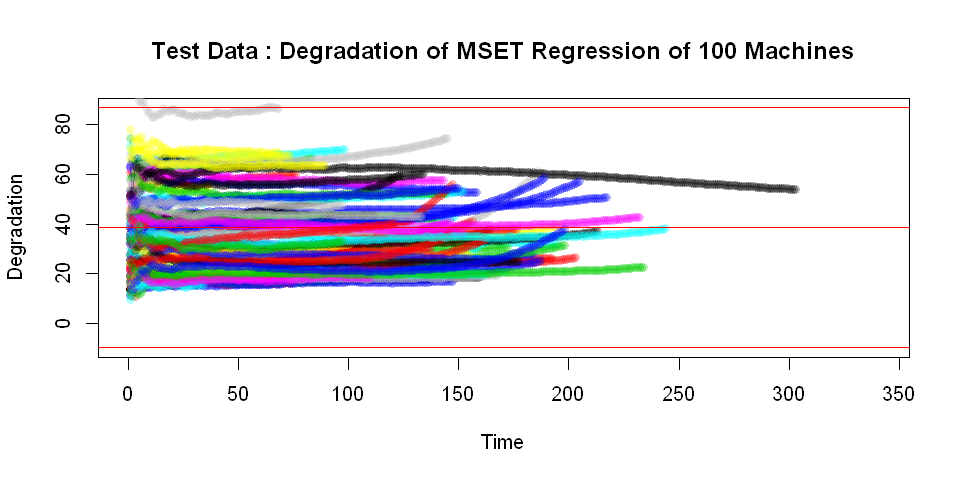

In [25]:
options(repr.plot.width = 8, repr.plot.height = 4)
plot(testdeg[test['Section-0']==1], pch=16, xlab='Time', ylab='Degradation', type='o', xlim = c(0,max(testEoL)), ylim=c(lPoF, uPoF))
for(machineNum in 2:100){
    points(testdeg[test['Section-0']==machineNum], pch=16, col=adjustcolor(machineNum, alpha=0.3), type='o')
 }
title("Test Data : Degradation of MSET Regression of 100 Machines")
abline(h=mean(PoFList), col='red')
abline(h=uPoF, col='red')
abline(h=lPoF, col='red')

- <h4> 위 그래프는 100대 Machine에 대한 Degradation을 나타냄 </h4>
- <h4> 그래프를 봤을때, Machine 별 Degradation 값이 차이가 굉장히 큼</h4>
- <h4> 이는, Degradation 값 변환이 불안정하고 이전에 Raw 데이터에서 발생했던 큰 불확실성이 Degradation 값으로 전이된 것으로 보임</h4>

## RUL Prediction : EWLR (Exponentially Weightd Linear Regression)

--------------------
information of RUL

current time: 146
predict time: 177.008
RUL: 31.008
--------------------

Test EoL : 218

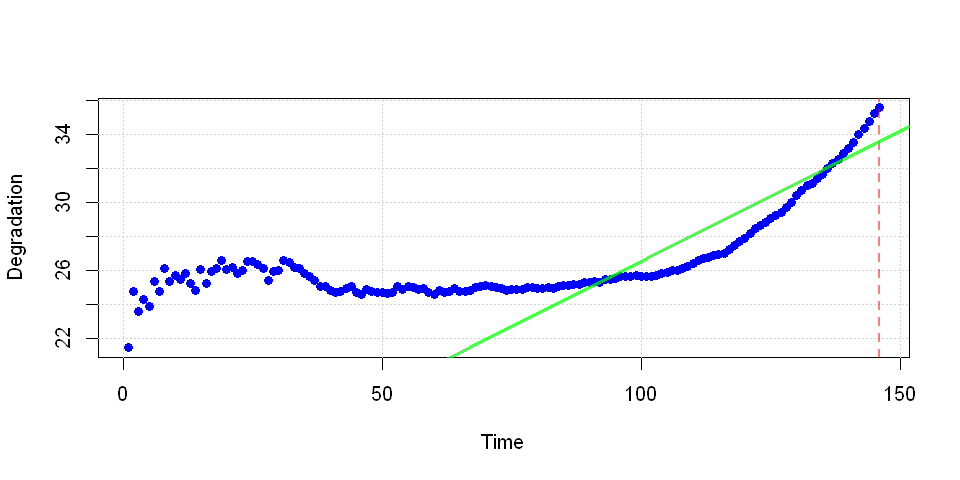

In [26]:
trainX = as.matrix(1:length(deg$'trdeg'))
trainY = as.matrix(deg$'trdeg')
testX = as.matrix(1:length(deg$'tsdeg'))
testY = as.matrix(deg$'tsdeg')

w = exponential_weight(1:nrow(testY),testY, alpha=0.05)
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,1))

RS = RULsystem(trainX, trainY, testX, testY, time=c(146,146), weight=w, mean_life=mean(trainEoL), alpha=0.05, failure_criteria = mean(PoF), model='WLR', plot_type=T)
cat(sprintf('Test EoL : %d', testEoL[machineNum]))

- <h4> 위 그래프는 MSET Regression -> Degradation Model -> PoF based RUL prediction을 나타냄 </h4>
- <h4> Machine 17, 82, 90 잔여수명 예측 결과 Machine 90은 수명예측이 가능한 것으로 보임 </h4>
- <h4> 하지만, Machine 17, 82의 경우 전조증상은 나타나지만 잔여수명 예측성능은 좋지 않음 </h4>
- <h4> 이는, PoF값이 원인으로 추정됨 </h4>

## 결론

- <h4> 해당 script는 Raw data를 활용한 이상감지 및 잔여수명 예측 가능 여부 판단을 목표로함 </h4>
- <h4> 본 프로세스는 Raw data -> MSET Regression -> Degradation Model -> PoF based RUL prediction 프로세스를 따름 </h4>
- <h4> 본 스크립트에서 발생한 문제는 다음과 같이 정의할 수 있음 </h4>

- <h4> Scaling 문제 </h4>
    
    - Raw data로 모델링을 할 경우 Scalar 값이 큰 변수의 영향력이 커지는 현상 발생
        
- <h4> 데이터 노이즈 문제 </h4>
    
    - 데이터의 변동성이 커서 패턴을 명확하게 추출할 수 없는 문제가 발생
    - 이는, 이상감지 통계량의 전조증상 발현에 영향을 미치며 Degradation 값에 영향을 줌
    - 즉 데이터 변동성이 큰 현상은 잔여수명 예측에 있어 큰 문제라고 볼 수 있음 
    
- <h4> PoF값의 부정확성 문제 </h4>

    - PoF 값은 Run-to-Failure 데이터의 각 설비 별 Degradation 평균을 사용하였음
    
    - 실험결과, Degradation 값이 PoF값을 조기에 통과한 문제가 발생하였는데, 이는 PoF 계산 고도화 필요성을 나타냄

- <h4> 결론적으로, 단순한 Raw 데이터를 이용해서 잔여수명 예측을 하는 것은 어려울 것으로 보임 </h4>